# Introduction to phylogenetic comparative methods in R
Goettingen 2023  
Andrew Hipp, ahipp@mortonarb.org  
Tutorial 02a: Phylogenetic Independent contrasts  
Use [static view in nbviewer](https://nbviewer.org/github/andrew-hipp/workshops/blob/master/2023-goettingen/Wk2-regressions/02a.PIC.ipynb) if you are not working directly in Jupyter notebooks.

### Session 2a: Felsenstein's method of independent contrasts

# Introduction to Phylogenetically Independent Contrasts
Joseph Felsenstein invented seminal tools for the fields of statistical phylogenetics (both the tools of maximum likelihood and adaptation of the bootstrap to phylogenetics) and phylogenetic comparative methods. Amazing... this from a Wisconsin-trained population geneticist (he studied with Jim Crow)! His paper on comparative methods is:

Felsenstein J. 1985. Phylogenies and the comparative method. American Naturalist 125: 1–15.

The method he developed is called phylogenetic independent contrasts (often abbreviated PIC), and it has probably been the most influential phylogenetic comparative method. While the method has mostly been superceded by phylogenetic generalized least squares (with which it is formally identical), PIC has computational advantages that may make it useful for very large phylogenies. Also, understanding the method will help you understand all that you do in analyzing phylogenetic comparative data. 


## The nature of the problem

Felsenstein (1985, points out that "species are part of a hierarchically structured phylogeny, and thus cannot be regarded for statistical purposes as if drawn independently from the same distribution." He proposes a solution, independent contrasts, an easily-calculated method of taking _n_ phylogenetically-structured data points and, under the assumption that they evolve according to a random-walk or Brownian motion process, rendering _n-1_ independent data points that can be analyzed using standard statistical methods, e.g. correlation or regression. 

What's the big deal? The problem is that two species that share an ancestor more recently are expected to look more similar than two species whose common ancestor is older. You can see what this looks like by simulating data under a random walk for two trees of two branches:

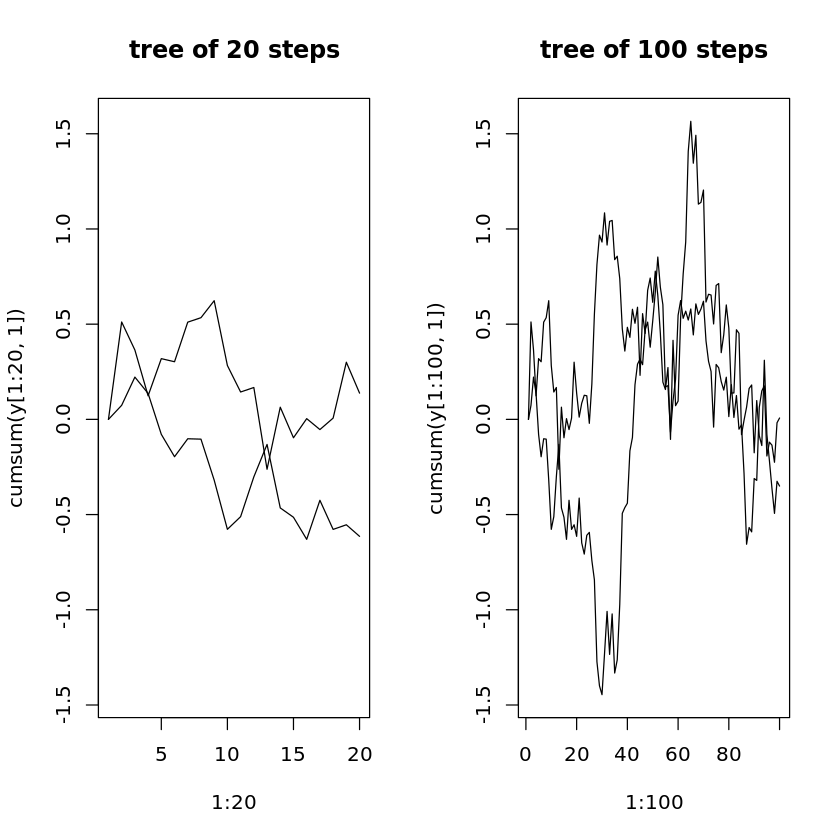

In [1]:
# first, let's simulate 100 datasets of 100 steps each:
y = sapply(1:50, function(x) c(0, rnorm(999, mean = 0, sd = 0.2))) # result is a matrix of random-normal vectors, 
                                                # centered on 0, with a sd of 0.2 
layout(matrix(1:2, 1)) # layout two plotting frames
plot(1:20, cumsum(y[1:20, 1]), 'l', ylim = range(c(cumsum(y[1:100, 1]), cumsum(y[1:100, 2]))), main = "tree of 20 steps")
lines(1:20, cumsum(y[1:20, 2]))
plot(1:100, cumsum(y[1:100, 1]), 'l', ylim = range(c(cumsum(y[1:100, 1]), cumsum(y[1:100, 2]))), main = "tree of 100 steps")
lines(1:100, cumsum(y[1:100, 2]))

You can see that while there is no guarantee that two species that are more similar just because they are more closely related, time introduces uncertainty in their character states, and this translates as higher variance. Thus, under Brownian motion, our expectation of the difference between character states for any two species is zero, but the standard deviation on this expectation increases with time since they diverged. Take a look:

At time = 20

   mean trait value = 0.06

   trait value variance = 0.61



At time = 50

   mean trait value = 0.14

   trait value variance = 2.04



At time = 100

   mean trait value = 0.26

   trait value variance = 4.79



At time = 1000

   mean trait value = 1.37

   trait value variance = 37.96





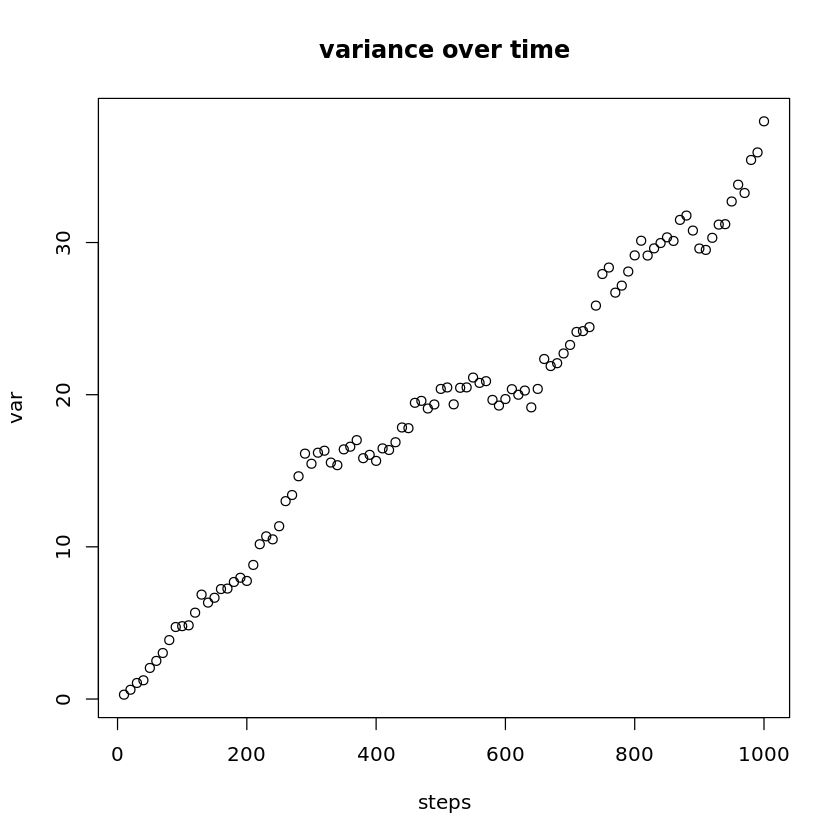

In [2]:
for(i in c(20, 50, 100, 1000)) {
    endpointOfEvolution <- apply(y[1:i, ], 2, sum)
    message(paste('At time =', i))
    message(paste('   mean trait value =', round(mean(endpointOfEvolution), 2)))
    message(paste('   trait value variance =', round(var(endpointOfEvolution), 2)))
    message('')
    }

steps <- seq(from = 10, to = 1000, by = 10) 
eoe <- data.frame(
    steps = steps,
    var = sapply(steps, function(i) {
        out <- apply(y[1:i, ], 2, sum) |> var()
        return(out)})
    )
plot(var ~ steps, data = eoe, main = 'variance over time')


This is the rationale behind Felsenstein's method. Let's see how it works.

## Simulating data and implementing PIC
First, start up ape and make a new tree and dataset:

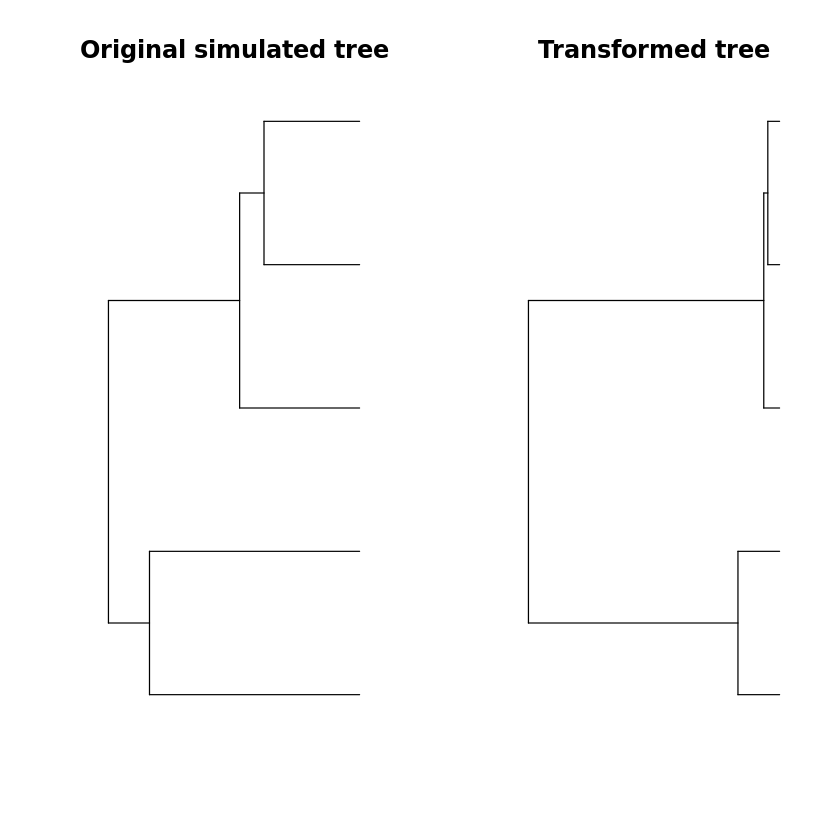

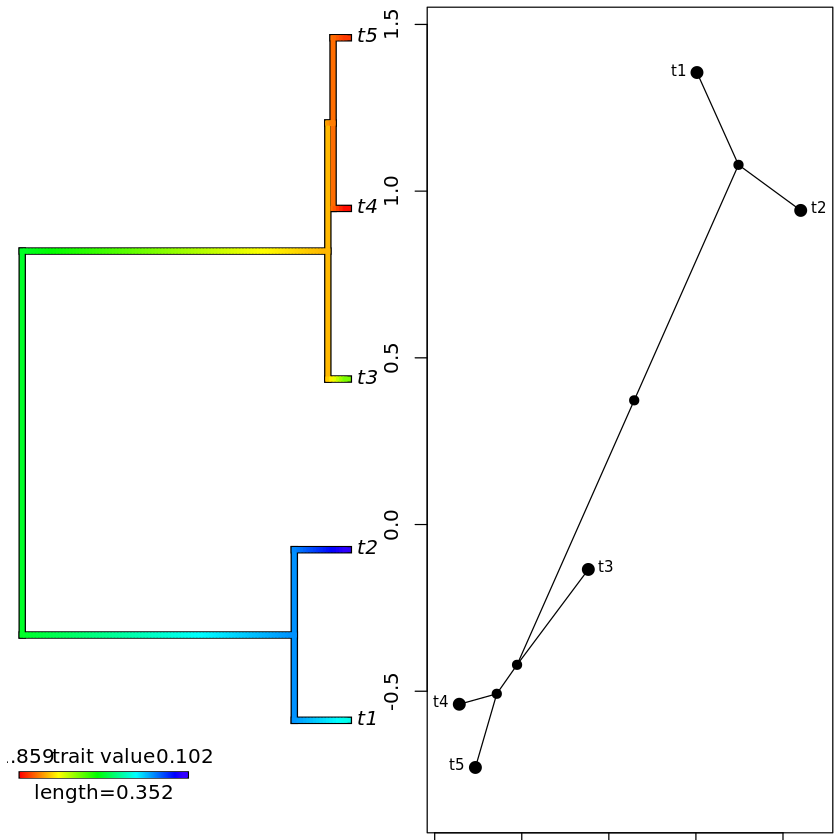

In [6]:
library(phytools)
library(geiger)
tr.raw <- pbtree(n=5) # a pure birth tree, because it's easy
tr <- rescale(tr.raw, 'delta', 0.1) ## rescale this to crank up the phylogenetic autocorrelation

layout(matrix(1:2, 1))
plot(tr.raw, show.tip.label = F, main = 'Original simulated tree')
plot(tr, show.tip.label = F, main = 'Transformed tree')


# an uncorrelated pair of characters on a phylogeny:
xy <- sim.char(tr, matrix(c(5,0,0,5), 2, byrow = T))[,,1]
## note that in the matrix above, the diagonals (5) are the variance; the off-diagonals (0) are covariance

dimnames(xy)[[2]] <- c('x', 'y')
layout(matrix(1:2, 1, 2))
fancyTree(tr, "contmap", x = xy[, 1])
phylomorphospace(tr, xy, label = 'horizontal', cex = 0.5)

This shows what phylogenetically autocorrelated data look like. Because the data points on this tree are not independent---close relatives are similar because they have a recent common ancestor---the independence assumption underlying essentially all traditional statistical methods is violated. If you simply regress x on y:


Call:
lm(formula = y ~ x, data = as.data.frame(xy))

Residuals:
     t1      t2      t3      t4      t5 
 0.6473 -0.3579 -0.2236  0.1079 -0.1736 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)   1.1990     0.3502   3.423   0.0417 *
x             0.9931     0.2755   3.604   0.0367 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4615 on 3 degrees of freedom
Multiple R-squared:  0.8124,	Adjusted R-squared:  0.7498 
F-statistic: 12.99 on 1 and 3 DF,  p-value: 0.03665



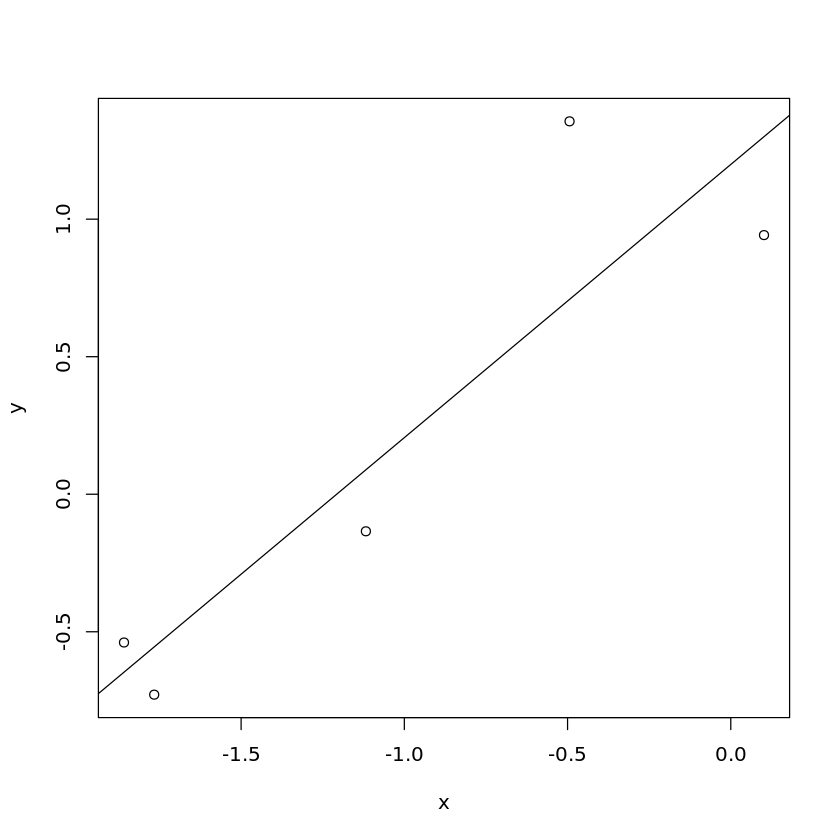

In [7]:
plot(xy)
abline(lm(y ~ x, as.data.frame(xy)))
print(summary(lm(y ~ x, as.data.frame(xy))))

... you'll infer that there is a strong, significant correlation between x and y. (Take a look at the regression results in the output above.) But having read Felsenstein (1985), you know that this is potentially spurius. While ordinary least squared regression or correlation gives an unbiased estimate of the relationship between two variables, the confidence interval on that estimate is generally biased downward, and the p-values are typically too small.

So how do we correct this? Let's try implementing independent contrasts. We'll start line-by-line, then wrap this into a function that can be called on any tree and dataset.

First, we order the tree so that it's easy to traverse. Ape has a function that reorders the tree so that navigating through the tree edge by edge yields a postorder traversal of the tree:

             endlabel
[1,] "9" "4" "t4"    
[2,] "9" "5" "t5"    
[3,] "8" "3" "t3"    
[4,] "8" "9" "9"     
[5,] "7" "1" "t1"    
[6,] "7" "2" "t2"    
[7,] "6" "7" "7"     
[8,] "6" "8" "8"     


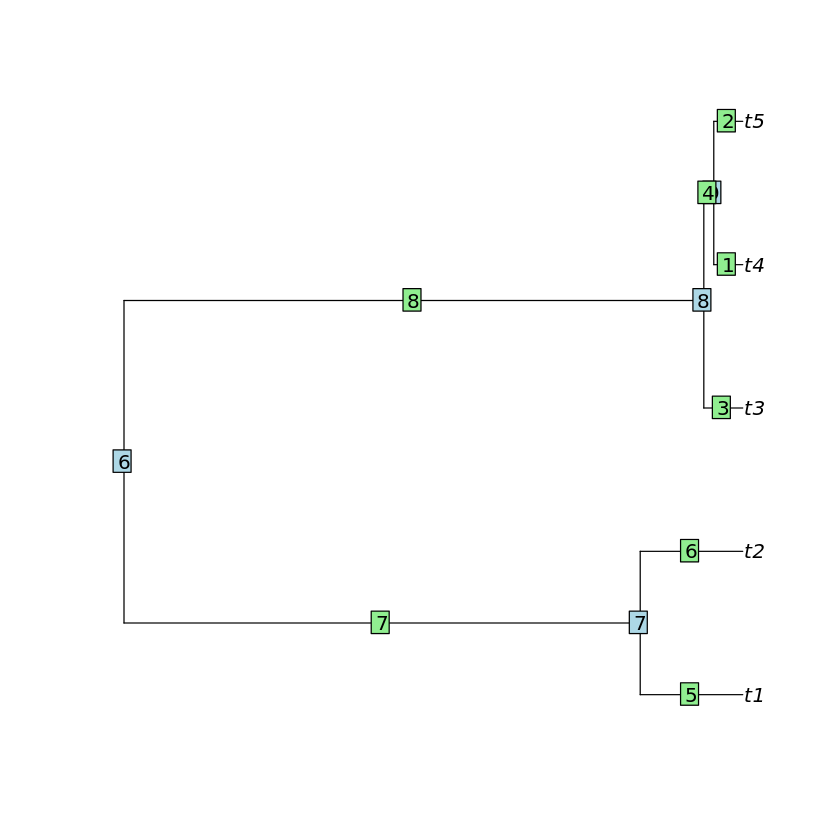

In [8]:
tr <- reorder(tr, 'postorder')
tr.orig <- tr # hanging onto this for now b/c we'll be mucking up the tree later
plot(tr)
nodelabels()
edgelabels()
# the following binds tip labels and node labels as a third column to the edge matrix
tr.edge <- cbind(tr$edge, endlabel = tr$tip.label[tr$edge[, 2]])
tr.edge[is.na(tr.edge[, 'endlabel']), 'endlabel'] <- 
  as.character(tr.edge[is.na(tr.edge[, 'endlabel']), 2])
print(head(tr.edge, 20)) # first 20 rows of the tr$edge, with tip labels

Here, the nodes are plotted with a blue background, the edges with a green background; numbers of the edges correspond to the order in which they are arranged in the reordered trees. On a dichotomous (fully bifurcating) tree, every consecutive pair of edges ending with an even number (e.g. 1 and 2, 11 and 12, 17 and 18) leads to the immediate ancestor of those two edges. By simply working down the edge matrix in order, you could easily implement the independent contrasts method by:

1. taking the edge-length weighted average of the tips or nodes stored at the ends of two edges;
2. storing the contrast in a vector numbered by nodes (note that the first nodes in a phylo object are actually the termini of the tips or leaves of the tree; it might be handy to copy the trait vector, order it by the tip labels, and keep adding to that as we make our nodes vector);
3. storing the normalizing factor in a second vector
4. modifying the length of the next edge
5. proceeding to the next pair of edges

Let's try it out. First, let's set up a vector with all the internal nodes and make a vector to fill up:

In [9]:
nodesToDo <- unique(tr$edge[, 1])
ind.contrasts <- rep(NA, length(nodesToDo))
names(ind.contrasts) <- sort(as.character(nodesToDo))

Now that we have this, we need a vector of the same structure to hold the variances by which the contrasts are normalized:

In [10]:
contrasts.sd <- ind.contrasts

Oh, shoot! I forgot: to get those contrasts, we have to save the weighted average at each node. So we'll make a vector of those as well, simply appending our trait vector (which already has the tip labels as names) to the contrasts vector (which is empty but handily named according to the node names):

In [11]:
x <- xy[, 1]
means <- c(x, ind.contrasts)
names(means)[which(names(means) %in% tr$tip.label)] <- 
  match(names(means)[which(names(means) %in% tr$tip.label)], tr$tip.label)
print(means) # make sure it looks right, and it does

         1          2          3          4          5          6          7 
-0.4939054  0.1017539 -1.1177669 -1.8587230 -1.7662120         NA         NA 
         8          9 
        NA         NA 


Okay. Let's do this! Knowing that the nodes are ordered according to "nodesToDo" -- we know this because of how we grabbed the data out, we'll just start working our way down the edge matrix, using a loop to do what we need to at each step:

In [12]:
for(working.node in nodesToDo) {
	# do a little book-keeping
    edges <- which(tr$edge[, 1] == working.node)
    desc.values <- means[as.character(tr$edge[edges, 2])]
    desc.lengths <- tr$edge.length[edges]
    branch.to.rescale <- which(tr$edge[, 2] == working.node)
    
    
    # 1. make and store the weighted average
    # means[as.character(working.node)] <- weighted.mean(desc.values, 1/desc.lengths)
    means[as.character(working.node)] <- sum(desc.values * (1/desc.lengths))/sum(1/desc.lengths)
    
    # 2. do the contrast and its sd
    ind.contrasts[as.character(working.node)] <- diff(desc.values)
    contrasts.sd[as.character(working.node)] <- sqrt(sum(desc.lengths))
	
    # 3. rescale the remaining branch
    tr$edge.length[branch.to.rescale] <-
      tr$edge.length[branch.to.rescale] +
        (desc.lengths[1] * desc.lengths[2]) / sum(desc.lengths)
	}



Now, let's compare our results with another implementation (ALWAYS a good idea if it's possible!). Look at the ace and pic functions in ape. Did we succeed in getting the ancestral states right? (Recall from Felsenstein that the root ancestral state estimated using independent contrasts is the maximumum likelihood estimate... but more on this in a bit). Let's check, using the ancestral character estimation function in ape:

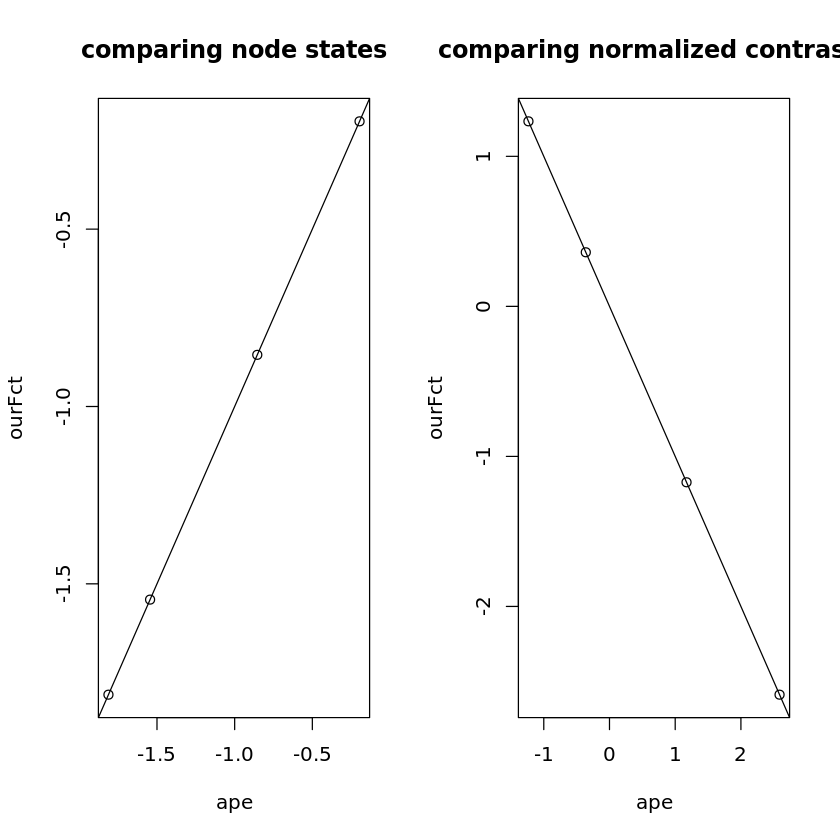

In [13]:
ancStatesCompare <- cbind(ape = ace(x, tr.orig, method = 'pic')$ace[as.character(nodesToDo)],
                          ourFct = means[as.character(nodesToDo)])
picCompare <- cbind(ape = pic(x, tr.orig)[as.character(nodesToDo)], 
                    ourFct = ind.contrasts[as.character(nodesToDo)] / contrasts.sd[as.character(nodesToDo)])
layout(matrix(1:2, 1))
plot(ancStatesCompare, main = "comparing node states")
abline(0, 1)
plot(picCompare, main = "comparing normalized contrasts")
abline(0, -1)

Alright! Looks good! You'll notice that our independent contrasts are simply the negative of ape's. No problem: the direction of the indendent contrasts is arbitrary. There's a nice discussion of this in Ted Garland's papers, in case you are interested.

Now that we've been able to do this, let's bundle our code into a function we can use. Why not just use ape? Because! It's more fun to code it yourself!

We'll make this a very simple function:

In [14]:
pic.workshop <- function(tr, dat, out = c('ancStates', 'contrasts'), normalized = TRUE) {
    ## set up our variables
    tr <- reorder(tr, 'postorder')
    nodesToDo <- unique(tr$edge[, 1])
    ic <- ic.sd <- rep(NA, length(nodesToDo))
    names(ic) <- names(ic.sd) <- sort(as.character(nodesToDo))
    means <- c(dat, ic)
    names(means)[which(names(means) %in% tr$tip.label)] <- 
      match(names(means)[which(names(means) %in% tr$tip.label)], tr$tip.label)
    
    for(working.node in nodesToDo) {
        # do a little book-keeping
        edges <- which(tr$edge[, 1] == working.node)
        desc.values <- means[as.character(tr$edge[edges, 2])]
        desc.lengths <- tr$edge.length[edges]
        branch.to.rescale <- which(tr$edge[, 2] == working.node)
    
    
        # 1. make and store the weighted average
        means[as.character(working.node)] <- weighted.mean(desc.values, 1/desc.lengths)
    
        # 2. do the contrast and its sd
        ic[as.character(working.node)] <- diff(desc.values)
        ic.sd[as.character(working.node)] <- sqrt(sum(desc.lengths))
        
        # 3. rescale the remaining branch
        tr$edge.length[branch.to.rescale] <-
            tr$edge.length[branch.to.rescale] +
            (desc.lengths[1] * desc.lengths[2]) / sum(desc.lengths)
        } # close working.node
    
    if(normalized) ic <- ic / ic.sd
    out <- cbind(ancStates = means[as.character(nodesToDo)],
                 contrasts = ic[as.character(nodesToDo)])[, out]
   return(out)
        }


And let's try it with our data:

,ancStates,contrasts
9,-1.8124675,0.3605232
8,-1.4651172,-2.3350203
7,-0.1960757,1.2333056
6,-0.8328827,-1.0713519


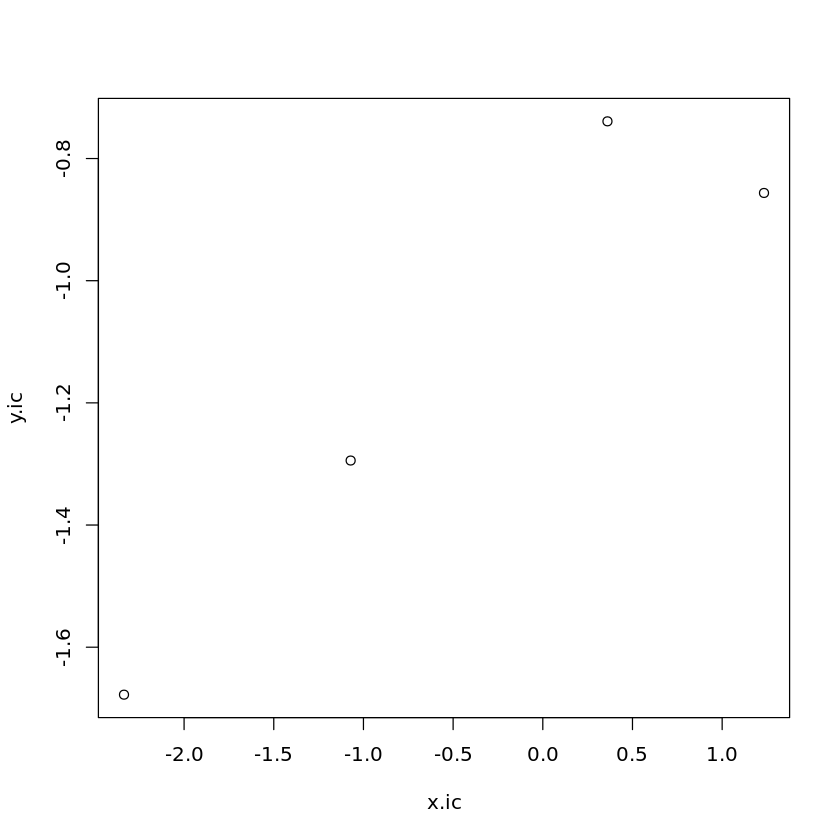

In [15]:
pic.workshop(tr,x)
x.ic <- pic.workshop(tr, xy[, 1], 'contrasts')
y.ic <- pic.workshop(tr, xy[, 2], 'contrasts')
plot(x.ic, y.ic)

And let's see if the correlation is still significant:

In [16]:
message('** Here are results from PIC **')
summary(lm(y.ic ~ x.ic + 0))
message('\n** Here are results from untransformed data**')
summary(lm(y ~ x, as.data.frame(xy)))

** Here are results from PIC **




Call:
lm(formula = y.ic ~ x.ic + 0)

Residuals:
      9       8       7       6 
-0.9131 -0.5509 -1.4515 -0.7774 

Coefficients:
     Estimate Std. Error t value Pr(>|t|)
x.ic   0.4826     0.3943   1.224    0.308

Residual standard error: 1.133 on 3 degrees of freedom
Multiple R-squared:  0.333,	Adjusted R-squared:  0.1107 
F-statistic: 1.498 on 1 and 3 DF,  p-value: 0.3084



** Here are results from untransformed data**




Call:
lm(formula = y ~ x, data = as.data.frame(xy))

Residuals:
     t1      t2      t3      t4      t5 
 0.6473 -0.3579 -0.2236  0.1079 -0.1736 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)   1.1990     0.3502   3.423   0.0417 *
x             0.9931     0.2755   3.604   0.0367 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4615 on 3 degrees of freedom
Multiple R-squared:  0.8124,	Adjusted R-squared:  0.7498 
F-statistic: 12.99 on 1 and 3 DF,  p-value: 0.03665


## To practice
On your own or with a partner, try out some of these exercises, ordered approximately by complexity. If the first exercises seem too simple, skip them and jump on to the next.

1. Simulate one tree of 50 tips and two datasets on that tree (x and y), using the simulation methods we used above or other R packages. Refer to the "Trait simulations" and "Tree simulations" paragraphs on the CRAN phylogenetics task view (https://cran.r-project.org/web/views/Phylogenetics.html). Generate independent contrasts for x and y, then calculate the correlation coefficient (cor.test in R) or least-squares regression coefficient of determination (lm in R) and p-values in R. Compare your analysis of the independent contrasts against your analysis of the untransformed data. 

2. Simulate 1000 trees of 50 tips each and two uncorrelated traits on each tree under a Brownian motion process. For each dataset, calculate the mean, the Pearson product-moment (cor.test), and the p-value for the correlation using both standard methods and independent contrasts. How often should you expect to find a P < 0.05? How often do you for both the PIC and standard methods? and which yields a better estimate of the mean? Is either biased? is there a lower variance to one or the other?

3. Modify our pic.35300 function to return Garland et al.'s confidence intervals on the root state of the tree.